## Food2Fork API ##
www.food2fork.com/about/api

In [18]:
import re
import requests
import urllib2
from urllib import quote
import json
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import nltk

In [19]:
%matplotlib inline

### API credentials ###

In [20]:
def loadCredentials():
    filename = 'secrets.txt'
    for line in open(filename).readlines():
        if "API" in line:    
            api_key = line.split(": ")[1].translate(None,'\n')
        
    return api_key

In [59]:
# Load the API Key
API_KEY = loadCredentials()

# Food2Fork links
_URL_API = 'http://food2fork.com/api/'
_URL_SEARCH = _URL_API + 'search?' + "key={0}".format(API_KEY)
_URL_GET = _URL_API + 'get?' + "key={0}".format(API_KEY)
_HEADER = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64)'}

### Search the Food2Fork API ###

In [60]:
def search(query, page=1):   
    """Return a list of recipes from the Food2Fork.com database"""

    # Format the request URL    
    api_request = _URL_SEARCH+"&q={query}&page={page}".format(query=query,page=page)

    # Make the request
    request  = urllib2.Request(api_request, headers=_HEADER)
    response = urllib2.urlopen(request)
    raw = response.read()
    json_obj = json.loads(raw)  
    
    return json_obj['recipes']       

In [93]:
# Search for chicken salad recipes
recipes = search('Chicken salad')
print(recipes[0]['image_url'])
recipes[0]

http://static.food2fork.com/Bacon2BWrapped2BJalapeno2BPopper2BStuffed2BChicken2B5002B5909939b0e65.jpg


{u'f2f_url': u'http://food2fork.com/view/35120',
 u'image_url': u'http://static.food2fork.com/Bacon2BWrapped2BJalapeno2BPopper2BStuffed2BChicken2B5002B5909939b0e65.jpg',
 u'publisher': u'Closet Cooking',
 u'publisher_url': u'http://closetcooking.com',
 u'recipe_id': u'35120',
 u'social_rank': 100.0,
 u'source_url': u'http://www.closetcooking.com/2012/11/bacon-wrapped-jalapeno-popper-stuffed.html',
 u'title': u'Bacon Wrapped Jalapeno Popper Stuffed Chicken'}

### Request a specific recipe from the API ###

In [90]:
def getRecipe(recipe_id):
    """Return the recipe specified by *recipe_id* from Food2Fork's database"""

    # Format the request URL
    api_request = _URL_GET+"&rId={ID}".format(ID=recipe_id)
    
    # Make the request
    request  = urllib2.Request(api_request, headers=_HEADER)
    response = urllib2.urlopen(request)
    raw = response.read()
    json_obj = json.loads(raw)  
    
    return json_obj['recipe']

In [92]:
r = getRecipe('35130')
r

{u'f2f_url': u'http://food2fork.com/view/35130',
 u'image_url': u'http://static.food2fork.com/BananasFosterPancakes15000eeed5d6.jpg',
 u'ingredients': [u'1 cup all purpose flour',
  u'1 teaspoon baking powder',
  u'1/4 teaspoon salt',
  u'1/4 teaspoon cinnamon',
  u'1 cup milk',
  u'1 egg',
  u'2 tablespoons brown sugar',
  u'2 tablespoons unsalted butter (melted)',
  u'2 overripe bananas (peeled and mashed)',
  u'2 tablespoons butter',
  u'2 tablespoons brown sugar',
  u'2 dashes of cinnamon',
  u'2 ripe bananas (peeled and sliced)',
  u'2 ounces dark rum\n'],
 u'publisher': u'Closet Cooking',
 u'publisher_url': u'http://closetcooking.com',
 u'recipe_id': u'35130',
 u'social_rank': 38.259222092243164,
 u'source_url': u'http://www.closetcooking.com/2010/05/bananas-foster-pancakes.html',
 u'title': u'Bananas Foster Pancakes'}

### Scrape ingredients from a Food2Fork.com page ###

In [95]:
recipes[0]

{u'f2f_url': u'http://food2fork.com/view/35120',
 u'image_url': u'http://static.food2fork.com/Bacon2BWrapped2BJalapeno2BPopper2BStuffed2BChicken2B5002B5909939b0e65.jpg',
 u'publisher': u'Closet Cooking',
 u'publisher_url': u'http://closetcooking.com',
 u'recipe_id': u'35120',
 u'social_rank': 100.0,
 u'source_url': u'http://www.closetcooking.com/2012/11/bacon-wrapped-jalapeno-popper-stuffed.html',
 u'title': u'Bacon Wrapped Jalapeno Popper Stuffed Chicken'}

In [110]:
def getIngredients(json_obj):
    r = getRecipe(json_obj['recipe_id'])
    return [i.strip('\n') for i in r['ingredients']]

In [111]:
def OLD_getIngredients(json_obj):
    URL = json_obj['f2f_url']
    page = requests.get(URL)
    html = BeautifulSoup(page.text, "html.parser")
    
    ingredientsList = html.find_all("li")
    ingredients = [i.text.strip('\n') for i in ingredientsList if ("ingredients" in i.decode()) and (i.text!='')] # Feels like a kludge...
    return ingredients

In [112]:
getIngredients(recipes[0])

[u'4 small chicken breasts, pounded thin',
 u'salt and pepper to taste',
 u'4 jalapenos, diced',
 u'4 ounces cream cheese, room temperature',
 u'1 cup cheddar cheese, shredded',
 u'8 slices bacon']

In [113]:
[(recipe['title'],getIngredients(recipe)) for recipe in recipes[:4]]

[(u'Bacon Wrapped Jalapeno Popper Stuffed Chicken',
  [u'4 small chicken breasts, pounded thin',
   u'salt and pepper to taste',
   u'4 jalapenos, diced',
   u'4 ounces cream cheese, room temperature',
   u'1 cup cheddar cheese, shredded',
   u'8 slices bacon']),
 (u'Buffalo Chicken Chowder',
  [u'2 tablespoons butter',
   u'1 pound chicken, cut into bite sized pieces',
   u'1 onion, diced',
   u'2 carrots, diced',
   u'2 stalks celery, diced',
   u'2 cloves garlic, chopped',
   u'1/4 cup flour (rice flour for gluten free)',
   u'3 cups chicken stock',
   u'hot sauce to taste (I used 1/4 cup Franks Red Hot sauce)',
   u'1 large yukon gold or other boiling potato, peeled and cut into bite sized pieces',
   u'salt and pepper to taste',
   u'1 cup heavy cream',
   u'1/4 cup blue cheese, crumbled']),
 (u'Zesty Slow Cooker Chicken Barbeque',
  [u'6 frozen skinless, boneless chicken breast halves',
   u'1 (12 ounce) bottle barbeque sauce',
   u'1/2 cup Italian salad dressing',
   u'1/4 cup b

## Use NLTK to parse amounts out from ingredients ##

In [ ]:
import nltk

In [130]:
re.findall("[0-9]",ingredients[0])

[u'1']

### Load json object from disk (for offline work) ###

In [18]:
raw = open("cookies.txt","r").read()
# raw = open("chicken.txt","r").read()
json_obj = json.loads(raw)

In [11]:
# This is how you save a json object as a text file. It's easy!
with open("cookies.txt","w") as outfile:
    json.dump(json_obj, outfile)

### Misc ###

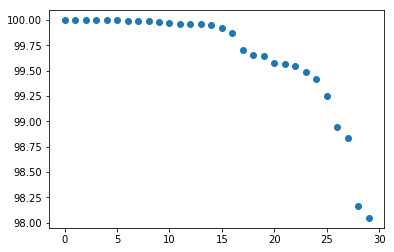

In [21]:
scores = [recipe['social_rank'] for recipe in json_obj]
plt.plot(scores,'o')
plt.show()